In [36]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(0)

In [37]:
# Feature lists
standard_features = ["DMP_5", "DMP_10", "DMN_5", "DMN_10", "MACD_8_21_5", "AO_5_10",
    "EMA_15", "MA_20", "KAMA_3_2_10", "CO", "C2O2", "C3O3",
    "net_add_ask_size", "net_add_bid_size", "Bollinger_Upper", "Bollinger_Lower"
]

minmax_features = [
    "ADX_10", "ADX_7", "ADX_5", "STOCHk_7_3_3", "STOCHd_7_3_3", "RSI_7", "time_since_open"
]

unscaled_features = ['market_session']
features = standard_features + minmax_features + unscaled_features

In [38]:
sampling_rate = "1s"
prediction_column = "Target_close"
batch_size = 16
epochs = 10
look_back = 32

In [ ]:
from tf_preprocessing import process_and_combine_data

start_date = "2024-10-02"
end_date = "2024-10-04"

all_data = process_and_combine_data(start_date, end_date, data_folder="../AAPL_data", sampling_rate=sampling_rate)

print(all_data.columns)

all_data.head()

Index(['trade_ask_size', 'trade_bid_size', 'net_add_ask_size',
       'net_add_bid_size', 'mid_price_high', 'mid_price_low',
       'mid_price_close', 'mid_price_open', 'max_depth', 'Returns',
       'Target_close', 'ADX_5', 'ADX_7', 'ADX_10', 'DMP_5', 'DMP_10', 'DMN_5',
       'DMN_10', 'AROONU_7', 'AROOND_7', 'OLL3', 'OLL5', 'OLL10', 'OLL15',
       'OHH3', 'OHH5', 'STOCHk_7_3_3', 'STOCHd_7_3_3', 'MACD_8_21_5', 'RSI_7',
       'AO_5_10', 'EMA_15', 'HMA_10', 'KAMA_3_2_10', 'MA_10', 'MA_20',
       'rmCO(3)', 'rmCO(4)', 'rmCO(5)', 'rmCO(6)', 'Bollinger_Upper',
       'Bollinger_Lower', 'U_minus_L', 'MA20dSTD', 'CO', 'C1O1', 'C2O2',
       'C3O3', 'range', 'OH1', 'time_since_open', 'dow_0', 'dow_1', 'dow_2',
       'dow_3', 'dow_4', 'market_session'],
      dtype='object')


,trade_ask_size,trade_bid_size,net_add_ask_size,net_add_bid_size,mid_price_high,mid_price_low,mid_price_close,mid_price_open,max_depth,Returns,...,C3O3,range,OH1,time_since_open,dow_0,dow_1,dow_2,dow_3,dow_4,market_session
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-02 10:00:48-04:00,400.0,0.0,127.0,-172.0,223.300,223.285,223.295,223.295,9.0,0.000000,...,-0.020,0.015,0.055,1848.0,0,0,1,0,0,0
2024-10-02 10:00:50-04:00,614.0,863.0,-784.0,2422.0,223.350,223.260,223.350,223.295,9.0,0.000246,...,0.055,0.090,0.005,1850.0,0,0,1,0,0,0
2024-10-02 10:00:52-04:00,110.0,115.0,333.0,312.0,223.375,223.350,223.365,223.350,9.0,0.000067,...,0.055,0.025,0.055,1852.0,0,0,1,0,0,0
2024-10-02 10:00:54-04:00,497.0,141.0,240.0,-1389.0,223.365,223.295,223.320,223.365,9.0,-0.000201,...,0.000,0.070,0.025,1854.0,0,0,1,0,0,0
2024-10-02 10:00:56-04:00,44.0,411.0,-854.0,1641.0,223.375,223.320,223.370,223.320,9.0,0.000224,...,0.055,0.055,0.000,1856.0,0,0,1,0,0,0


In [40]:
all_data.Target_close.value_counts()

Target_close
2.0    24848
0.0    23470
1.0    20814
Name: count, dtype: int64

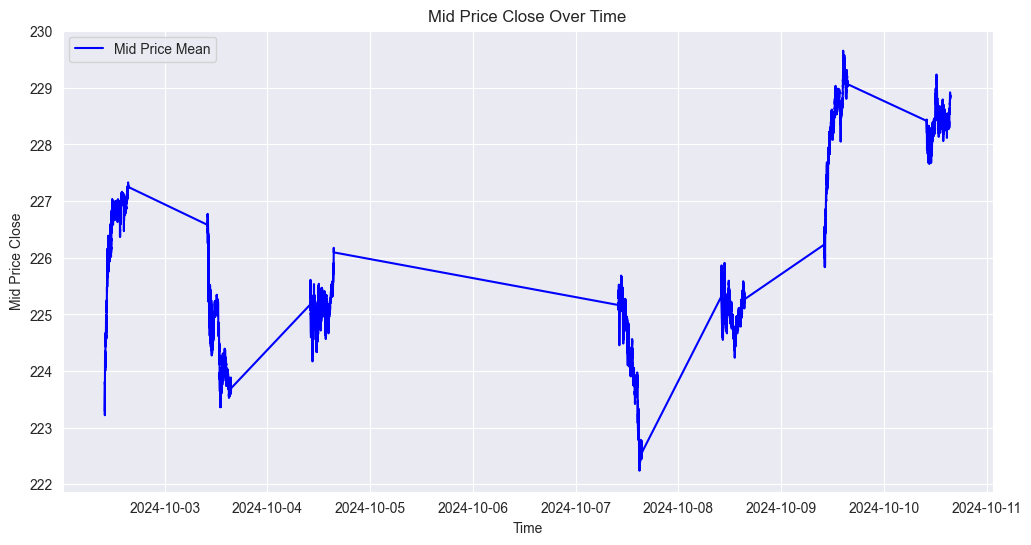

In [41]:
sns.set_style("darkgrid")

plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data["mid_price_close"], label="Mid Price Mean", color="blue")
plt.xlabel("Time")
plt.ylabel("Mid Price Close")
plt.title("Mid Price Close Over Time")
plt.legend()
plt.show()

In [42]:
# Data Splitting
train_size = int(len(all_data) * 0.7)
val_size = int(len(all_data) * 0.1)
test_size = len(all_data) - train_size - val_size

train_df = all_data.iloc[:train_size, :]
val_df = all_data.iloc[train_size:train_size + val_size, :]
test_df = all_data.iloc[train_size + val_size:, :]

In [ ]:
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter

standard_indices = [features.index(f) for f in standard_features]
minmax_indices = [features.index(f) for f in minmax_features]
unscaled_indices = [features.index(f) for f in unscaled_features]

class TimeSeriesScalerGenerator(Sequence):
    def __init__(self, data, target, look_back, batch_size=32, oversample=False, **kwargs):
        """
        Custom Timeseries Generator with per-sequence scaling and optional oversampling.
        
        Args:
            data (pd.DataFrame): DataFrame with feature columns.
            target (str): Target column name.
            look_back (int): Number of past time steps per sample.
            batch_size (int): Batch size.
            oversample (bool): Whether to oversample minority classes.
        """
        super().__init__(**kwargs)  # Call the parent class constructor with kwargs

        self.data = data[features].values  # Extract feature matrix
        self.targets = data[target].values.astype(int)  # Extract target labels
        self.look_back = look_back
        self.batch_size = batch_size
        self.indices = np.arange(len(data) - look_back)
        self.true_labels = self._extract_true_labels()

        # Oversample minority classes if enabled
        if oversample:
            self._oversample_minority_classes()

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        """Generates one batch of data."""
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]

        # Extract sequences efficiently using list slicing
        batch_data = np.array([self.data[i : i + self.look_back] for i in batch_indices])

        # Preallocate arrays for batch
        X_batch = np.empty((len(batch_indices), self.look_back, len(features)), dtype=np.float32)
        y_batch = np.empty(len(batch_indices), dtype=np.int32)

        # Scale each sequence individually
        for i, seq in enumerate(batch_data):
            standard_scaler = StandardScaler()
            minmax_scaler = MinMaxScaler(feature_range=(0, 1))

            seq_standard = standard_scaler.fit_transform(seq[:, standard_indices])
            seq_minmax = minmax_scaler.fit_transform(seq[:, minmax_indices])
            seq_unscaled = (
                seq[:, unscaled_indices] 
                if unscaled_features else np.empty((self.look_back, 0))
            )

            X_batch[i] = np.hstack((seq_standard, seq_minmax, seq_unscaled))
            y_batch[i] = self.targets[batch_indices[i] + self.look_back]

        return X_batch, y_batch
    
    def _extract_true_labels(self):
        """Extract all true labels for the entire dataset."""
        return np.array([self.targets[i + self.look_back] for i in self.indices])

    def _oversample_minority_classes(self):
        """Oversample minority classes by duplicating their sequences."""
        # Count class distribution
        class_counts = Counter(self.true_labels)
        max_count = max(class_counts.values())

        # Collect indices for each class
        class_indices = {label: np.where(self.true_labels == label)[0] for label in class_counts}

        # Oversample minority classes
        oversampled_indices = []
        for label, indices in class_indices.items():
            repeat_count = max_count // len(indices)  # Number of times to repeat the minority class
            oversampled_indices.extend(np.repeat(indices, repeat_count))
            oversampled_indices.extend(np.random.choice(indices, max_count % len(indices), replace=True))

        # Update indices and true_labels
        self.indices = np.array(oversampled_indices)
        self.true_labels = self.true_labels[self.indices]



In [ ]:
train_gen = TimeSeriesScalerGenerator(train_df, prediction_column, look_back, batch_size, oversample=True)
val_gen = TimeSeriesScalerGenerator(val_df, prediction_column, look_back, batch_size)
test_gen = TimeSeriesScalerGenerator(test_df, prediction_column, look_back, batch_size)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping
from keras import layers

# early_stop = EarlyStopping(
#     monitor="val_loss",  # Monitor validation loss
#     patience=3,          # Stop after 3 epochs of no improvement
#     restore_best_weights=True  # Restore best weights after stopping
# )


input_size = len(features)

inputs = layers.Input(shape=(look_back, input_size))

# First LSTM layer
x = layers.LSTM(128, return_sequences=True)(inputs)
x = layers.BatchNormalization()(x)

# MultiHeadAttention requires query, key, value (use same for self-attention)
attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x, x)
x = layers.Add()([x, attn_output])  # Residual connection (optional)
x = layers.LayerNormalization()(x)
x = layers.Dropout(0.2)(x)  # Dropout after attention

# Second LSTM layer
x = layers.LSTM(64, return_sequences=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Dense layers
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

# Train Model
model.fit(train_gen, validation_data=val_gen, epochs=epochs)

Epoch 1/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 93s 28ms/step - accuracy: 0.3659 - loss: 1.1836 - val_accuracy: 0.3406 - val_loss: 1.1660
Epoch 2/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 85s 28ms/step - accuracy: 0.3987 - loss: 1.0854 - val_accuracy: 0.3489 - val_loss: 1.1587
Epoch 3/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 91s 30ms/step - accuracy: 0.3987 - loss: 1.0835 - val_accuracy: 0.3552 - val_loss: 1.1018
Epoch 4/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 92s 30ms/step - accuracy: 0.3865 - loss: 1.0883 - val_accuracy: 0.3495 - val_loss: 1.1184
Epoch 5/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 88s 29ms/step - accuracy: 0.3881 - loss: 1.0857 - val_accuracy: 0.3550 - val_loss: 1.1101
Epoch 6/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 89s 29ms/step - accuracy: 0.3917 - loss: 1.0840 - val_accuracy: 0.3552 - val_loss: 1.1151
Epoch 7/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 113s 37ms/step - accuracy: 0.3767 - loss: 1.0893 - val_accuracy: 0.3404 - val_loss: 1.1152
Epoch 8/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 122s 40ms/step - accuracy: 0.3759

In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def plot_evaluation_metrics(y_true, y_pred, log_probabilities):
    probabilities = np.exp(log_probabilities)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Confusion Matrix (updated for 3 classes)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[0],
        xticklabels=["Down (0)", "Constant (1)", "Up (2)"],  # Updated class labels with meaning
        yticklabels=["Down (0)", "Constant (1)", "Up (2)"],  # Updated class labels with meaning
    )
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # Histogram of Predicted Probabilities (updated for 3 classes)
    for i, class_label in enumerate(["Down (0)", "Constant (1)", "Up (2)"]):  # Updated class labels with meaning
        sns.histplot(
            probabilities[y_true == i][:, i], bins=30, label=class_label, ax=axes[1]
        )
    axes[1].set_title("Probability Distribution")
    axes[1].set_xlabel("Predicted Probability")
    axes[1].legend()

    # Scatter Plot of Predictions (updated for 3 classes)
    scatter = sns.scatterplot(
        x=np.arange(len(probabilities)),
        y=probabilities.max(axis=1),
        hue=y_true,
        palette={0: "red", 1: "blue", 2: "green"},  # Updated palette for 0, 1, 2
        alpha=0.7,
        ax=axes[2],
    )
    axes[2].set_title("Scatter Plot of Predictions")
    axes[2].set_xlabel("Sample Index")
    axes[2].set_ylabel("Max Predicted Probability")

    handles, labels = scatter.get_legend_handles_labels()
    new_labels = ["Down (0)", "Constant (1)", "Up (2)"]  # Updated class labels with meaning
    axes[2].legend(handles, new_labels, title="True Class")

    axes[2].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # Print Evaluation Metrics
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))

863/863 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step


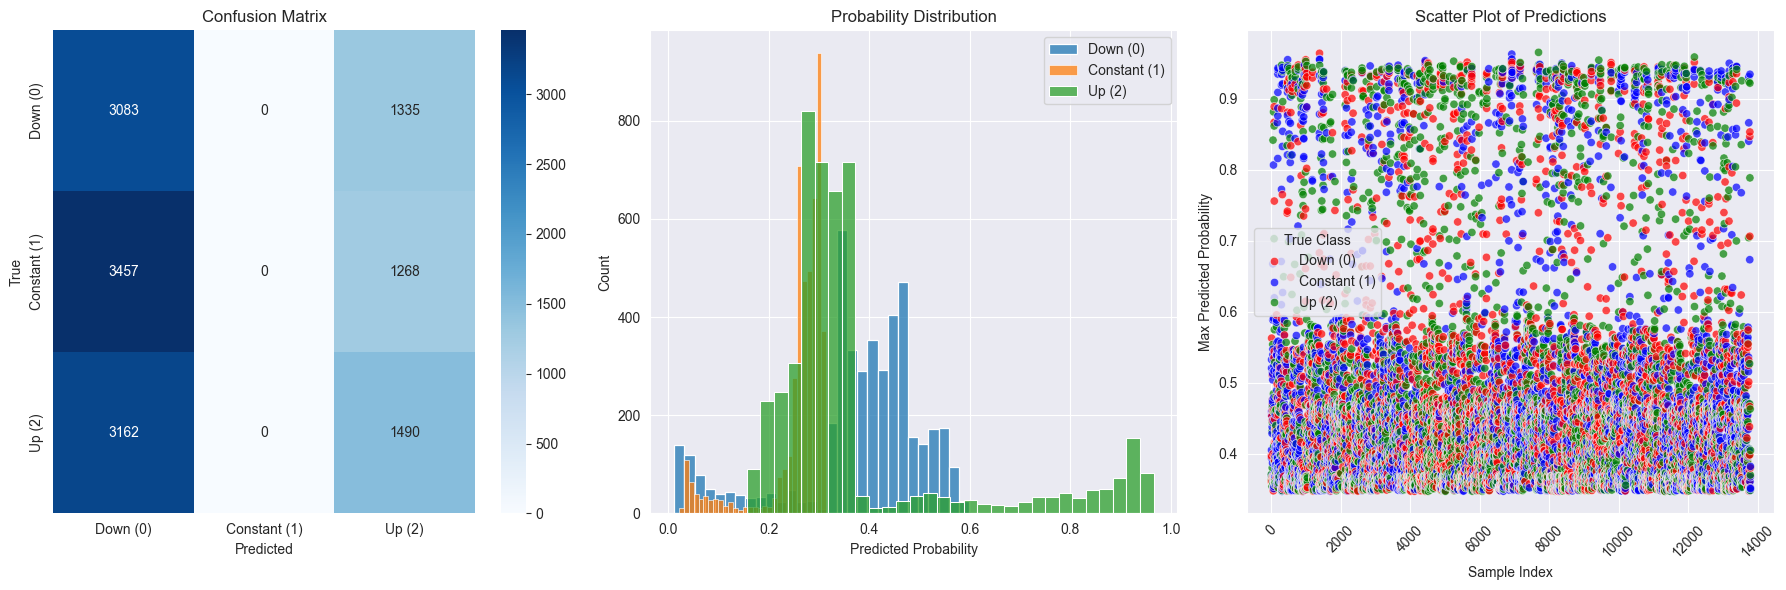

Accuracy: 0.3315
              precision    recall  f1-score   support

           0       0.32      0.70      0.44      4418
           1       0.00      0.00      0.00      4725
           2       0.36      0.32      0.34      4652

    accuracy                           0.33     13795
   macro avg       0.23      0.34      0.26     13795
weighted avg       0.22      0.33      0.25     13795



In [47]:
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
log_probabilities = np.log(y_pred_prob)

y_test = test_gen.true_labels

# Assuming y_test is the true labels for the test set
plot_evaluation_metrics(y_test, y_pred, log_probabilities)

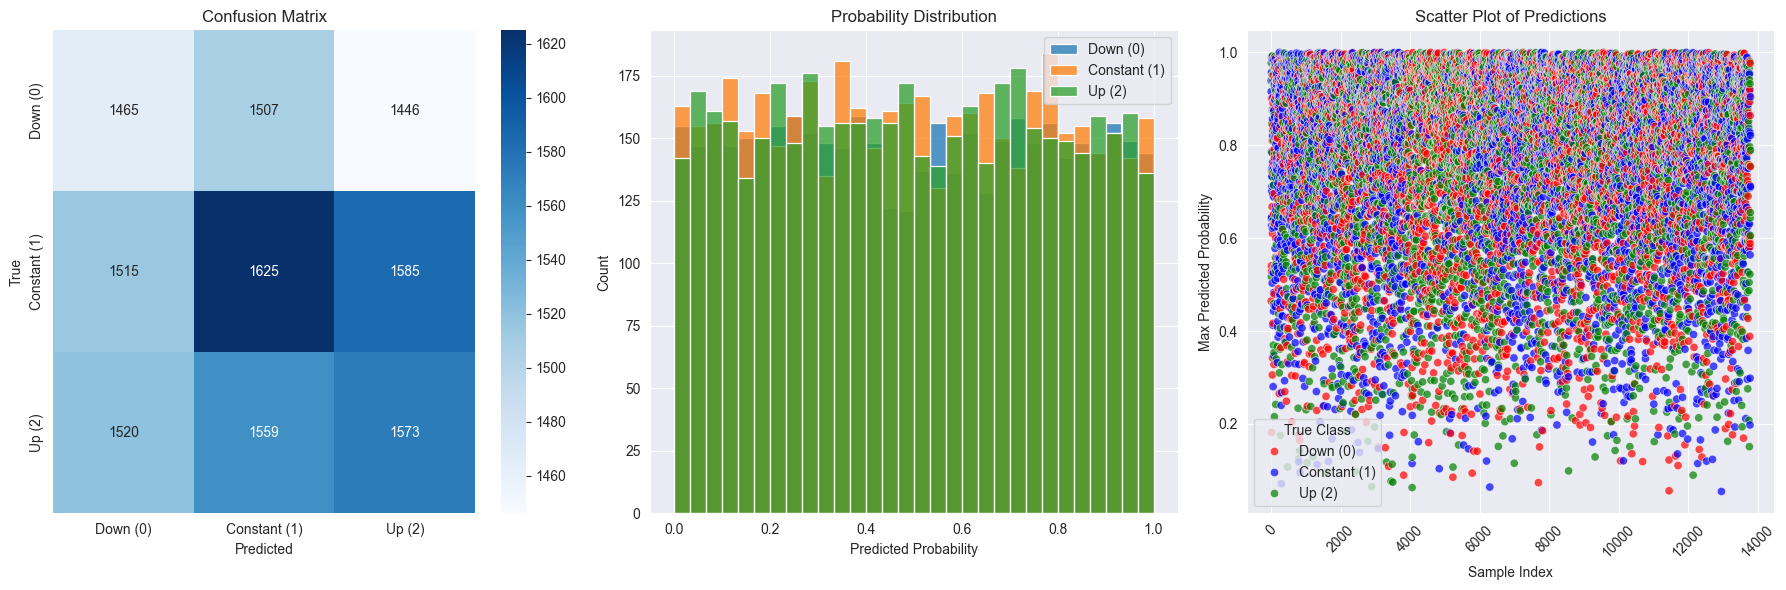

Accuracy: 0.3380
              precision    recall  f1-score   support

           0       0.33      0.33      0.33      4418
           1       0.35      0.34      0.35      4725
           2       0.34      0.34      0.34      4652

    accuracy                           0.34     13795
   macro avg       0.34      0.34      0.34     13795
weighted avg       0.34      0.34      0.34     13795



In [48]:
# Implement a random strategy
random_y_pred = np.random.randint(0, 3, size=len(y_test))
random_log_probabilities = np.log(np.random.rand(len(y_test), 3))

# Plot evaluation metrics for the random strategy
plot_evaluation_metrics(y_test, random_y_pred, random_log_probabilities)